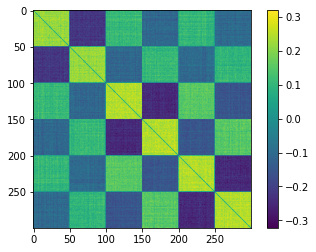

In [1159]:
import numpy as np
import matplotlib.pyplot as plt

dim = 2000

nr = 300
nv = 300
nt = 300

a1 = np.random.normal(0,1.1,dim)
a2 = np.random.normal(0,1,dim)
a3 = np.random.normal(0,1,dim)

a12 = np.random.normal(0,1.5,dim)
a13 = np.random.normal(0,1.5,dim)
a23 = np.random.normal(0,2,dim)

a123 = np.random.normal(0,1,dim)

h = 1#np.random.normal(0,1,dim)

groups = []

sigma = 5

for i,n in enumerate([nr,nv,nt]):
    groups.append([])
    for a,b,c,d in zip([a1,a2,a3],[a12,a12,a13],[a13,a23,a23],[a123,a123,a123]):
        groups[i].append(np.repeat([a*h+b*h+c*h+d*h],int(n/6),axis=0) 
                         + np.random.normal(0,sigma,(int(n/6),dim)))
        groups[i].append(-np.repeat([a*h+b*h+c*h+d*h],int(n/6),axis=0) 
                         + np.random.normal(0,sigma,(int(n/6),dim)))
    groups[i] = np.concatenate(groups[i])

def mask(E):
    return (np.ones(E.shape[0])-np.eye(E.shape[0]))*E
                       
plt.imshow(mask(np.corrcoef(groups[0])))
plt.colorbar()
plt.show()

In [1160]:
br = np.repeat([[1,0,0]],nr/6,axis=0)
bv = np.repeat([[1,0,0]],nv/6,axis=0)
bt = np.repeat([[1,0,0]],nt/6,axis=0)

yr = np.concatenate([br, br[:,[1,0,2]], br[:,[1,2,0]]])
yv = np.concatenate([bv, bv[:,[1,0,2]], bv[:,[1,2,0]]])
yt = np.concatenate([bt, bt[:,[1,0,2]], bt[:,[1,2,0]]])

gr = groups[0]
gv = groups[1]
gt = groups[2]

print(yr.shape)
print(yv.shape)
print(yt.shape)

(150, 3)
(150, 3)
(150, 3)


In [1161]:
rIdcs = np.arange(nr)
rvIdcs = np.arange(nr+nv)
vIdcs = np.arange(nr,nr+nv)
tIdcs = np.arange(nr+nv,nr+nv+nt)

print([min(rIdcs),max(rIdcs)])
print([min(rvIdcs),max(rvIdcs)])
print([min(vIdcs),max(vIdcs)])
print([min(tIdcs),max(tIdcs)])

[0, 299]
[0, 599]
[300, 599]
[600, 899]


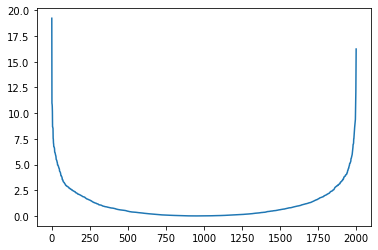

In [1162]:
from scipy.ndimage import filters

idcs = np.argsort(h*a1)

plt.plot(((h*a1)[idcs])**2)
plt.show()

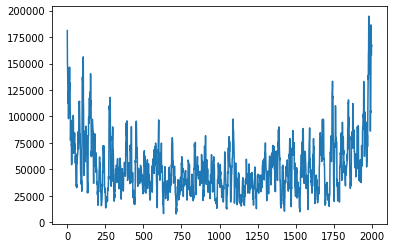

In [1163]:
from cca_zoo.models import rCCA, KTCCA

# cca = rCCA(latent_dims=10,c=[0,0])
cca = KTCCA(latent_dims=5)
cca.fit((gv, gv))
load = cca.get_loadings((gv[0:50], gv[0:50]))[0]

corr = np.einsum('ab,bc->bc',gv[0:50],load)
corr = np.sum(np.abs(corr), axis=1)

ker = np.ones(10)/10
sigCorr = filters.convolve1d(corr[idcs], ker)

plt.plot(sigCorr)
plt.show()

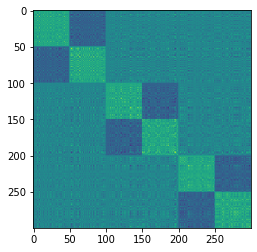

In [1164]:
tfm = cca.transform((gv[0:300], gv[0:300]))[0]
plt.imshow(tfm@tfm.T)
plt.show()

In [1165]:
import torch

X = torch.from_numpy(np.concatenate([gr, gv, gt])).float().cuda()
y = torch.from_numpy(np.concatenate([yr, yv, yt])).float().cuda()

print(X.shape)
print(y.shape)

torch.Size([900, 2000])
torch.Size([450, 3])


In [1177]:
torch.cartesian_prod(torch.arange(1,5), torch.arange(3))

/home/anton/.conda/envs/torch/lib/python3.7/site-packages/torch/functional.py:1069: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811797118/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.cartesian_prod(tensors)  # type: ignore[attr-defined]


tensor([[1, 0],
        [1, 1],
        [1, 2],
        [2, 0],
        [2, 1],
        [2, 2],
        [3, 0],
        [3, 1],
        [3, 2],
        [4, 0],
        [4, 1],
        [4, 2]])

In [1183]:
import torch
import torch.nn as nn
import torch.nn.functional as F

mseLoss = torch.nn.MSELoss()
ceLoss = torch.nn.CrossEntropyLoss()

def mask(e):
    return e - torch.diag(torch.diag(e.detach()))

def obj(res, a0, a1, b0, b1, n):
    tgt = torch.zeros(n,n).float().cuda()
    for i,a in enumerate([a0, a1, b0, b1]):
        for j,b in enumerate([a0, a1, b0, b1]): 
            c = torch.cartesian_prod(a,b)
            print(c)
            raise 'Bad'
            v = 1 if (i+j)%2 == 0 else -1
            tgt[c] = v
            break
        break
    return mseLoss(res, tgt), tgt

class LatSim(nn.Module):
    def __init__(self, inp, dp=0.1):
        super(LatSim, self).__init__()
        nl = nn.Parameter(1e-4*torch.randn(inp.shape[-1],400).float().cuda())
        self.active = nn.ParameterList([nl])
        self.dp = nn.Dropout(p=dp)
    
    def getLatentsAndEdges(self, x, i):
#         e = 1e-10
#         y = x*self.active[i].permute(1,0)
        y = torch.einsum('ac,ce->ae', x, self.active[i])
        e = y@y.T
        return y, e
        
    def forward(self, x):
        x = self.dp(x)
        res = []
        _, e = self.getLatentsAndEdges(x, 0)
        e = mask(e)
#         e[e == 0] = float('-inf')
#         e = F.softmax(e, dim=1) 
        return e

nEpochs = 5000
pPeriod = 100

for i in range(1):
    sim = LatSim(X, 0.5)
    optim = torch.optim.Adam(sim.parameters(), lr=1e-4, weight_decay=1e-4)
    
    for epoch in range(nEpochs):
        optim.zero_grad()
        e = sim(X[rIdcs])
        loss, tgt = obj(e, torch.arange(0,50), torch.arange(50,100), 
                        torch.arange(100,150), torch.arange(150,200), nr)
        loss.backward()
        optim.step()
        if epoch % pPeriod == 0 or epoch == nEpochs-1:
            print(f'epoch {epoch} loss={(float(loss))}')
    print('Finished training')

tensor([[ 0,  0],
        [ 0,  1],
        [ 0,  2],
        ...,
        [49, 47],
        [49, 48],
        [49, 49]])


TypeError: exceptions must derive from BaseException

In [1172]:
e = sim(X)

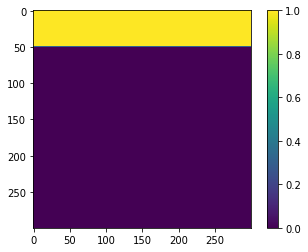

In [1182]:
plt.imshow(tgt.detach().cpu().numpy())
plt.colorbar()
plt.show()

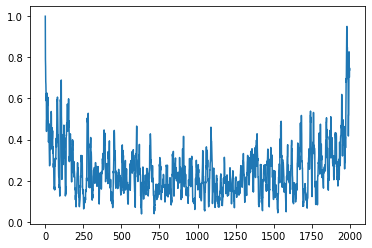

In [1174]:
con = torch.einsum('ab,bc->bc',X[vIdcs][0:50],sim.active[0][:,:])
con = torch.einsum('bc,bc->b',con,con).detach().cpu().numpy()

ker = np.ones(10)/10
sigSim = filters.convolve1d(np.abs(con[idcs]), ker)

plt.plot(sigSim/max(sigSim))
plt.show()

In [1175]:
# sigSimA13 = sigSim
print(sigSimA1[0:5])

[0.38543314 0.30468568 0.2912728  0.26305    0.2571534 ]


/home/anton/.conda/envs/torch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/anton/.conda/envs/torch/lib/python3.7/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


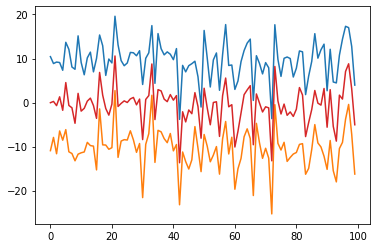

In [608]:
muA1 = np.mean(gr[0:500], axis=0)
muA2 = np.mean(gr[500:1000], axis=0)

plt.plot(np.amax(gr[0:100,0:100], axis=0))
plt.plot(np.amin(gr[0:100,0:100], axis=0))
plt.plot(muA2[0:100])
plt.plot(muA1[0:100])
# plt.plot(th[0:100])
plt.show()

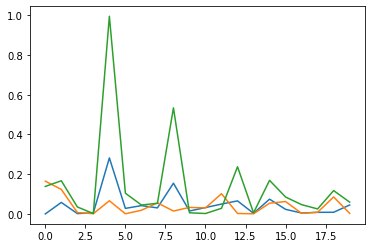

In [504]:
cScore = np.abs((muA1+muA2)/(muA1-muA2))

plt.plot(np.abs(muA1[50:70])/10)
plt.plot(np.abs(muA2[50:70])/10)
# plt.plot(cScore[50:70]/80)
plt.plot(np.abs((a1*h)[50:70])/3)
# plt.plot(np.abs(h[50:70]))
plt.show()

In [508]:
np.corrcoef(np.abs(muA1),np.abs(a1*h))

array([[1.        , 0.84815995],
       [0.84815995, 1.        ]])